# Game of Life

Game of Life, introduced by Conway is a 2D cellular automaton that simulates a world populated by cells.  The world is a 2D square grid that is, in principle, infinite.  Each grid position represents a cell that can be either alive, or dead.  The game is played over a number of generations.  To compute the next generation, each grid position is considered indepedently. The rules are straightforward:

* If a cell in generation $t$ is alive,
  * it is alive in generation $t + 1$ if it has either two or three life neighbours in generation $t$;
  * it is dead in generation $t + 1$ otherwise.
* If a cell in generation $t$ is dead,
  * it is alive in generatino $t + 1$ if it has exactly three neighbours in generation $t$;
  * it is dead in generation $t + 1$ otherwise.
  
Each cell has eight neighbours.  Typically, the Game of Life world is represented by an $n \times n$ array, and periodic boundary conditions are applied to simulate an infinite world.

## Required imports

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
import numpy as np

## World representation

A Game of Life world will be represented by an array of integers.  Each array element represents a cell that can either be dead (0) or alive (1).  First, we define a class that represents a world, and that is initialized from a given numpy array.  This will serve as a base class for classes that implement specific initializations.  Typically, those should override `__init__`.  The `World` base class defines all methods to compute the next generation, get information on the world's state, as well a string representation.

In [2]:
class World:
    
    def __init__(self, cells):
        self._world = np.copy(cells.astype(np.int8))
        self._tmp_world = np.empty_like(self._world)
    
    @property
    def shape(self):
        return self._world.shape
    
    @property
    def nr_alive(self):
        return np.sum(self._world)

    @property
    def cells(self):
        return np.copy(self._world)

    @property
    def fraction_alive(self):
        return np.sum(self._world)/(self.shape[0]*self.shape[1])
    
    def is_alive(self, i, j):
        return self._world[i, j] == 1
    
    def nr_neignbours(self, i, j):
        up = (i + self.shape[0] - 1) % self.shape[0]
        down = (i + 1) % self.shape[0]
        left = (j + self.shape[1] - 1) % self.shape[1]
        right = (j + 1) % self.shape[1]
        return (self._world[up, left] + self._world[up, j] +
                    self._world[up, right] +
                self._world[i, left] + self._world[i, right] +
                self._world[down, left] + self._world[down, j] +
                    self._world[down, right])
    
    def next_generation(self):
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                nr_nb = self.nr_neignbours(i, j)
                if self.is_alive(i, j):
                    self._tmp_world[i, j] = 1 if nr_nb == 2 or nr_nb == 3 else 0
                else:
                    self._tmp_world[i, j] = 1 if nr_nb == 3 else 0
        self._world = self._tmp_world


        
    def __repr__(self):
        return '\n'.join(' '.join(f'{self._world[i, j]:1d}'
                                  for j in range(self.shape[1]))
                         for i in range(self.shape[0]))

### Random world

The `RandomWorld` class inherits from the `World` basse class, and initializes a world of $n \times n$ randomly, but where a fraction $f_{\rm alive}$ is alive.

In [3]:
class RandomWorld(World):
    
    def __init__(self, n, f_alive):
        super().__init__(np.random.choice(np.array([0, 1], dtype=np.int8),
                                          (n, n), p=(1 - f_alive, f_alive)))

Create a world and run a generation.

In [4]:
world = RandomWorld(10, 0.4)
world

0 0 0 0 1 0 0 0 0 1
0 0 0 0 0 1 0 1 0 0
0 1 0 0 1 0 0 0 1 1
1 1 0 1 0 1 0 1 1 1
1 0 0 0 1 1 0 1 1 0
1 0 0 1 0 0 1 0 0 0
0 1 1 0 0 0 1 0 0 0
1 0 0 0 0 0 0 0 0 0
0 0 0 1 0 1 0 0 0 1
0 0 0 0 0 1 0 1 0 0

In [5]:
world.next_generation()
print(world)

0 0 0 0 1 1 0 0 1 0
1 0 0 0 1 1 0 0 0 1
0 1 1 0 1 1 0 0 0 0
0 1 1 1 0 1 0 0 0 0
0 0 1 1 0 1 0 0 0 0
1 0 1 1 1 0 1 0 0 1
1 1 1 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0 0 0
0 0 0 0 1 0 1 0 0 0
0 0 0 0 0 1 1 0 1 0


### Patch world

A second, interesting way to initialize a world is from a numpy array representing an $p_0 \times p_1$ patch in the $n \times n$ world, where, obviously, $p_0 \le n$ and $p_1 \le n$.

In [4]:
class PatchWorld(World):
    
    def __init__(self, n, patch):
        world = np.zeros((n, n))
        world[0:patch.shape[0], 0:patch.shape[1]] = patch
        super().__init__(world)

In [5]:
world = PatchWorld(10, np.array([[1, 0, 0], [1, 1, 0]]))
world

1 0 0 0 0 0 0 0 0 0
1 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0

## Simulation runner

We define a class to conveniently perform a complete simulation.  At most `max_gen` generations are computed, but the computation stops as soon as a cycle is detected.

In [6]:
class WorldRunner:
    
    def __init__(self, world, max_gen):
        self._world = world
        self._max_gen = max_gen
        self._cycle_length = None
        self._hist = [self._world.cells]
    
    @property
    def max_gen(self):
        return self._max_gen

    @property
    def nr_generations(self):
        return len(self._hist) - 1
    
    def has_cycle(self):
        return self._cycle_length is not None
    
    @property
    def cycle_length(self):
        return self._cycle_length
    
    @property
    def history(self):
        return self._hist
    
    def _has_cycle(self):
        for gen in range(-2, -len(self._hist), -1):
            if np.all(self._hist[-1] == self._hist[gen]):
                self._cycle_length = -gen - 1
                return True
        return False
    
    def run(self):
        for _ in range(1, self.max_gen + 1):
            self._world.next_generation()
            self._hist.append(self._world.cells)
            if self._has_cycle():
                break

Create a world, and run it for a number of generations, then check on the properties.

In [10]:
world = RandomWorld(10, 0.3)
runner = WorldRunner(world, 100)
runner.run()

The current state of the world can be checked.

In [11]:
world

1 1 1 1 0 1 1 0 1 0
0 0 0 0 0 1 1 0 1 0
0 0 0 0 0 1 1 0 0 0
1 0 1 0 1 0 1 0 0 1
0 1 0 1 0 1 1 0 1 0
1 0 0 1 0 0 1 0 1 0
0 1 1 0 0 1 1 0 1 0
1 0 0 0 0 0 0 0 0 0
1 0 0 0 0 0 0 1 1 0
1 0 1 1 1 1 0 0 1 0

In [12]:
world.fraction_alive

0.41

Check whether a cycle has been detected, what the cycle length is, and after how many generations it occured.

In [13]:
runner.has_cycle()

False

In [14]:
runner.cycle_length

In [15]:
runner.nr_generations

100

## Simulation visualization

In [16]:
class WorldView:
    
    def __init__(self, world_runner):
        self._world_runner = world_runner
        self._nr_gen = world_runner.nr_generations
        self._figure, self._axes = plt.subplots()
        self._axes.get_xaxis().set_visible(False)
        self._axes.get_yaxis().set_visible(False)
    
    @property
    def figure(self):
        return self._figure

    def create_animation(self):
        return FuncAnimation(self.figure, self.create_animate(),
                             init_func=self.create_init(),
                             frames=self._world_runner.nr_generations)
        
    def create_animate(self):
        def animate(i):
            self._axes.imshow(self._world_runner.history[i])
        return animate

    def create_init(self):
        def init():
            self._axes.imshow(self._world_runner.history[0])
        return init

In [17]:
world_size = 10
f_alive = 0.3
max_generations = 100
world = RandomWorld(world_size, f_alive)
world_runner = WorldRunner(world, max_generations)
world_runner.run()

In [18]:
world_runner.nr_generations

89

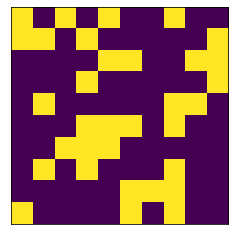

In [19]:
world_view = WorldView(world_runner)
animation = world_view.create_animation()

HTML(animation.to_jshtml(default_mode='once'))

In [20]:
world

1 1 0 0 0 0 0 1 1 1
0 0 0 1 1 1 1 0 0 0
1 1 1 1 0 0 0 1 1 1
0 0 0 0 0 1 1 0 0 0
1 1 1 1 1 0 0 1 1 1
0 0 0 0 0 1 1 0 0 0
1 1 1 0 1 0 0 1 1 1
0 0 1 0 1 1 1 0 0 0
1 1 0 0 0 0 0 1 1 1
0 0 1 1 1 1 1 0 0 0

In [21]:
world_runner.cycle_length

1

## Simulation statistics